# Deep Learning for Market Movement Prediction

In [255]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from keras.models import Sequential         # Model type
from keras.layers import Dense              # Layers  
from keras.optimizers import Adam, RMSprop  # Optimizers

## Data Preparation

In [256]:
# Import data
data = pd.read_csv('Kucoin_BTCUSDT_1h.csv')
data = data.set_index('Time')
data.round(4).head()

,Open,High,Low,Close,Volume,Amount
Time,,,,,,
01/01/2019 00:00,3700.1709,3714.5718,3690.5661,3700.3683,3.0644,11348.1603
01/01/2019 01:00,3701.6228,3702.0822,3685.7531,3687.6851,3.6307,13419.4868
01/01/2019 02:00,3687.5345,3692.8131,3679.9838,3687.8867,1.9861,7319.2636
01/01/2019 03:00,3690.0000,3699.2613,3687.3615,3692.3558,4.5664,16853.7124
01/01/2019 04:00,3697.0000,3709.6029,3690.0000,3697.0334,1.2229,4526.6382


In [257]:
# Calculate the discrete returns and define the direction as a binary column
data['return'] = data['Close']/data['Close'].shift(1) - 1

data['direction'] = np.where(data['return'] > 0, 1, 0)

data.head()

,Open,High,Low,Close,Volume,Amount,return,direction
Time,,,,,,,,
01/01/2019 00:00,3700.170853,3714.571764,3690.566100,3700.368284,3.064360,11348.160330,NaN,0
01/01/2019 01:00,3701.622819,3702.082234,3685.753131,3687.685134,3.630704,13419.486790,-0.003428,0
01/01/2019 02:00,3687.534508,3692.813102,3679.983792,3687.886662,1.986100,7319.263562,0.000055,1
01/01/2019 03:00,3689.999999,3699.261284,3687.361524,3692.355821,4.566440,16853.712350,0.001212,1
01/01/2019 04:00,3696.999985,3709.602927,3690.000000,3697.033403,1.222852,4526.638151,0.001267,1


### Create Features

In [258]:
# Create the lagged data
lags = 5

features = []
for lag in range(1, lags + 1):
    feature = f'lag_{lag}'
    data[feature] = data['return'].shift(lag)
    features.append(feature)
    
# Delete row containing NaN values
# data.dropna(inplace=True)
data.round(4).head()

,Open,High,Low,Close,Volume,Amount,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Time,,,,,,,,,,,,,
01/01/2019 00:00,3700.1709,3714.5718,3690.5661,3700.3683,3.0644,11348.1603,NaN,0,NaN,NaN,NaN,NaN,NaN
01/01/2019 01:00,3701.6228,3702.0822,3685.7531,3687.6851,3.6307,13419.4868,-0.0034,0,NaN,NaN,NaN,NaN,NaN
01/01/2019 02:00,3687.5345,3692.8131,3679.9838,3687.8867,1.9861,7319.2636,0.0001,1,-0.0034,NaN,NaN,NaN,NaN
01/01/2019 03:00,3690.0000,3699.2613,3687.3615,3692.3558,4.5664,16853.7124,0.0012,1,0.0001,-0.0034,NaN,NaN,NaN
01/01/2019 04:00,3697.0000,3709.6029,3690.0000,3697.0334,1.2229,4526.6382,0.0013,1,0.0012,0.0001,-0.0034,NaN,NaN


In [259]:
# Additional Features
data['momentum'] = data['return'].rolling(5).mean().shift(1)

data['volatility'] = data['return'].rolling(20).std().shift(1)

data['distance'] = (data['Close'] - data['Close'].rolling(50).mean().shift(1)) # consider changing to percentage distance

data.round(4).tail()

,Open,High,Low,Close,Volume,Amount,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Time,,,,,,,,,,,,,,,,
04/07/2022 21:00,19778.5,20025.0,19749.0,19956.8,363.2141,7.222108e+06,0.0090,1,-0.0026,-0.0050,0.0017,0.0080,-0.0032,-0.0002,0.0066,642.890
04/07/2022 22:00,19956.9,20255.0,19872.0,20166.4,799.4776,1.601910e+07,0.0105,1,0.0090,-0.0026,-0.0050,0.0017,0.0080,0.0022,0.0067,838.814
04/07/2022 23:00,20164.6,20354.0,20115.1,20235.9,850.5198,1.721385e+07,0.0034,1,0.0105,0.0090,-0.0026,-0.0050,0.0017,0.0027,0.0066,890.256
05/07/2022 00:00,20235.0,20489.0,20184.0,20403.5,1203.2726,2.449700e+07,0.0083,1,0.0034,0.0105,0.0090,-0.0026,-0.0050,0.0031,0.0066,1040.282
05/07/2022 01:00,20403.6,20429.0,20353.2,20371.7,177.3406,3.615895e+06,-0.0016,0,0.0083,0.0034,0.0105,0.0090,-0.0026,0.0057,0.0067,987.066


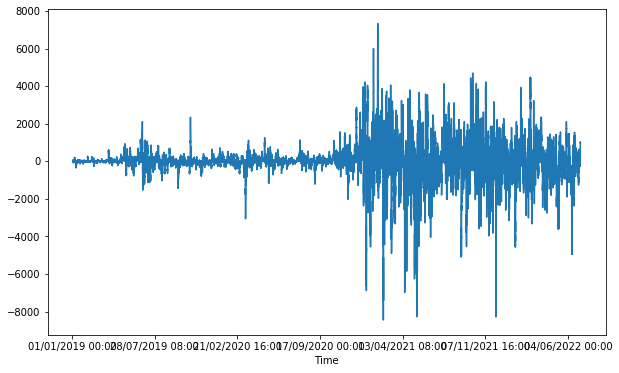

In [260]:
data['distance'].plot(figsize=(10,6))

In [261]:
data.round(4).head()

,Open,High,Low,Close,Volume,Amount,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Time,,,,,,,,,,,,,,,,
01/01/2019 00:00,3700.1709,3714.5718,3690.5661,3700.3683,3.0644,11348.1603,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01/01/2019 01:00,3701.6228,3702.0822,3685.7531,3687.6851,3.6307,13419.4868,-0.0034,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01/01/2019 02:00,3687.5345,3692.8131,3679.9838,3687.8867,1.9861,7319.2636,0.0001,1,-0.0034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01/01/2019 03:00,3690.0000,3699.2613,3687.3615,3692.3558,4.5664,16853.7124,0.0012,1,0.0001,-0.0034,NaN,NaN,NaN,NaN,NaN,NaN
01/01/2019 04:00,3697.0000,3709.6029,3690.0000,3697.0334,1.2229,4526.6382,0.0013,1,0.0012,0.0001,-0.0034,NaN,NaN,NaN,NaN,NaN


In [262]:
# Delete rows containing NaN values
data.dropna(inplace=True)
data.round(4).head()

,Open,High,Low,Close,Volume,Amount,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Time,,,,,,,,,,,,,,,,
03/01/2019 02:00,3831.5200,3844.4278,3827.8686,3830.4819,3.0749,11787.0356,-0.0003,0,-0.0011,-0.0054,-0.0014,0.0016,0.0025,-0.0008,0.0039,74.0495
03/01/2019 03:00,3834.2616,3846.1419,3834.2616,3842.3300,3.0982,11903.7973,0.0031,1,-0.0003,-0.0011,-0.0054,-0.0014,0.0016,-0.0013,0.0036,83.2954
03/01/2019 04:00,3842.3300,3850.0000,3832.7045,3832.7045,8.9400,34365.7409,-0.0025,0,0.0031,-0.0003,-0.0011,-0.0054,-0.0014,-0.0010,0.0036,70.5770
03/01/2019 05:00,3832.7045,3840.0000,3809.4407,3823.2755,3.4146,13042.7354,-0.0025,0,-0.0025,0.0031,-0.0003,-0.0011,-0.0054,-0.0012,0.0037,58.2516
03/01/2019 06:00,3822.5831,3836.1886,3815.8429,3823.4137,7.7010,29479.6857,0.0000,1,-0.0025,-0.0025,0.0031,-0.0003,-0.0011,-0.0007,0.0037,55.7715


### Training and Test Data Sets

In [263]:
train_size = 6000
test_size = 720     # 30 Days

In [264]:
# dataset columns
cols = features.copy()
cols.append('direction')

dataset = data[cols] # Leave the return column in this dataset as it will be required later.

dataset.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
Time,,,,,,
03/01/2019 02:00,-0.0011,-0.0054,-0.0014,0.0016,0.0025,0
03/01/2019 03:00,-0.0003,-0.0011,-0.0054,-0.0014,0.0016,1
03/01/2019 04:00,0.0031,-0.0003,-0.0011,-0.0054,-0.0014,0
03/01/2019 05:00,-0.0025,0.0031,-0.0003,-0.0011,-0.0054,0
03/01/2019 06:00,-0.0025,-0.0025,0.0031,-0.0003,-0.0011,1


In [265]:
# Training Dataset
training_data = dataset[:train_size].copy()

training_data.round(4).tail()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
Time,,,,,,
09/09/2019 21:00,-0.0080,0.0057,-0.0015,0.0013,-0.0060,1
09/09/2019 22:00,0.0053,-0.0080,0.0057,-0.0015,0.0013,1
09/09/2019 23:00,0.0051,0.0053,-0.0080,0.0057,-0.0015,0
10/09/2019 00:00,-0.0027,0.0051,0.0053,-0.0080,0.0057,1
10/09/2019 01:00,0.0030,-0.0027,0.0051,0.0053,-0.0080,0


In [266]:
# Test Dataset
test_data = dataset[train_size:(train_size+test_size)].copy()

test_data.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
Time,,,,,,
10/09/2019 02:00,-0.0006,0.0030,-0.0027,0.0051,0.0053,0
10/09/2019 03:00,-0.0046,-0.0006,0.0030,-0.0027,0.0051,1
10/09/2019 04:00,0.0023,-0.0046,-0.0006,0.0030,-0.0027,0
10/09/2019 05:00,-0.0004,0.0023,-0.0046,-0.0006,0.0030,0
10/09/2019 06:00,-0.0037,-0.0004,0.0023,-0.0046,-0.0006,1


In [267]:
# Standardize the datasets
mu, std = training_data.mean(), training_data.std()

training_data_ = (training_data - mu)/std

training_data_.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
Time,,,,,,
03/01/2019 02:00,-0.1736,-0.7515,-0.2187,0.1841,0.3171,-1.0498
03/01/2019 03:00,-0.0666,-0.1734,-0.7515,-0.2186,0.1841,0.9524
03/01/2019 04:00,0.3924,-0.0664,-0.1735,-0.7515,-0.2185,-1.0498
03/01/2019 05:00,-0.3649,0.3925,-0.0664,-0.1734,-0.7515,-1.0498
03/01/2019 06:00,-0.3588,-0.3647,0.3925,-0.0663,-0.1733,0.9524


In [268]:
# Standardize the test dataset
test_data_ = (test_data - mu)/std

test_data_.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction
Time,,,,,,
10/09/2019 02:00,-0.1072,0.3758,-0.3898,0.6623,0.6925,-1.0498
10/09/2019 03:00,-0.6454,-0.1070,0.3758,-0.3897,0.6624,0.9524
10/09/2019 04:00,0.2857,-0.6452,-0.1070,0.3759,-0.3897,-1.0498
10/09/2019 05:00,-0.0851,0.2859,-0.6453,-0.1069,0.3759,-1.0498
10/09/2019 06:00,-0.5316,-0.0849,0.2859,-0.6452,-0.1069,0.9524


### The Model

In [269]:
# Specify the optimizer
optimizer = Adam(learning_rate=0.0001)

In [270]:
# Set seeds
def set_seeds(seed=100):
    #random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)
    
set_seeds()

In [271]:
# Specify the Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(features),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [272]:
%%time
# Fit the Model
model.fit(training_data_[features], 
          training_data['direction'],
         epochs=50, verbose=False,
         validation_split=0.2, shuffle=False)

Wall time: 9.89 s


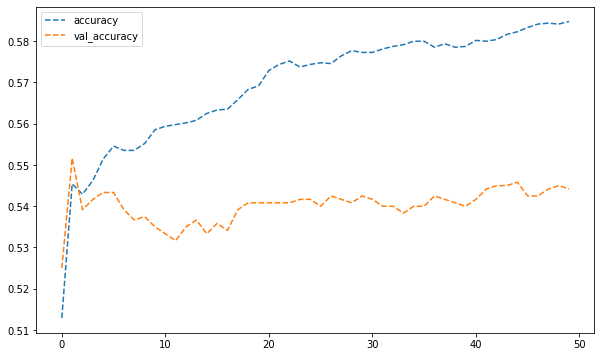

In [273]:
res = pd.DataFrame(model.history.history)

res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [274]:
# Evaluate model
model.evaluate(training_data_[features], training_data['direction'])

6000/6000 [==============================] - 0s 20us/step


[0.6720658930142721, 0.5761666893959045]

In [275]:
# Predictions
pred = np.where(model.predict(training_data_[features]) > 0.5, 1, 0)
pred[:30].flatten()

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0])

In [276]:
# Calculate the strategy returns given the positions

training_data['prediction'] = np.where(pred > 0, 1, -1)

# add return column to training_data
training_data['return'] = data[:train_size]['return']

# strategy returns
training_data['strategy'] = (training_data['prediction'] * training_data['return'])

training_data.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,direction,prediction,return,strategy
Time,,,,,,,,,
03/01/2019 02:00,-0.001091,-0.005365,-0.001425,0.001551,0.002534,0,1,-0.000300,-0.000300
03/01/2019 03:00,-0.000300,-0.001091,-0.005365,-0.001425,0.001551,1,1,0.003093,0.003093
03/01/2019 04:00,0.003093,-0.000300,-0.001091,-0.005365,-0.001425,0,1,-0.002505,-0.002505
03/01/2019 05:00,-0.002505,0.003093,-0.000300,-0.001091,-0.005365,0,1,-0.002460,-0.002460
03/01/2019 06:00,-0.002460,-0.002505,0.003093,-0.000300,-0.001091,1,1,0.000036,0.000036


In [277]:
# Total return
(1 + training_data[['return','strategy']]).prod()

return       2.695928
strategy    16.566785
dtype: float64

In [278]:
# Export to check in excel:


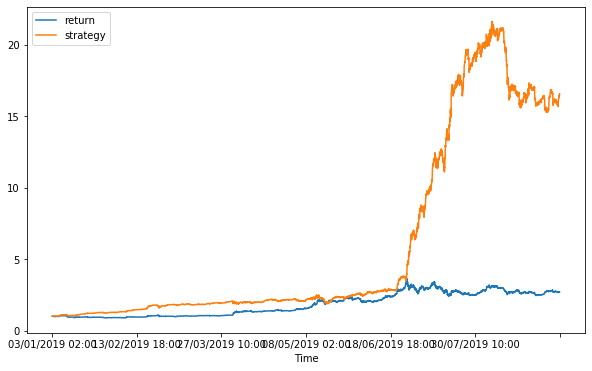

In [279]:
# Plot strategy performance (in-sample)
(1 + training_data[['return','strategy']]).cumprod().plot(figsize=(10,6))

#### Perfomance of model on Test Data

In [280]:
# Perfomance of model on test data
model.evaluate(test_data_[features], test_data['direction'])

720/720 [==============================] - 0s 35us/step


[0.6973613566822476, 0.5236111283302307]

In [281]:
# Predictions
pred = np.where(model.predict(test_data_[features]) > 0.5, 1, 0)

test_data['prediction'] = np.where(pred > 0 , 1, -1)

test_data['prediction'].value_counts()

 1    537
-1    183
Name: prediction, dtype: int64

In [282]:
# Add returns column
test_data['return'] = data[train_size:(train_size + test_size)]['return']

# Calculate strategy returns
test_data['strategy'] = (test_data['prediction'] * test_data['return'])

(1 + test_data[['return','strategy']]).prod()

return      0.825805
strategy    0.888871
dtype: float64

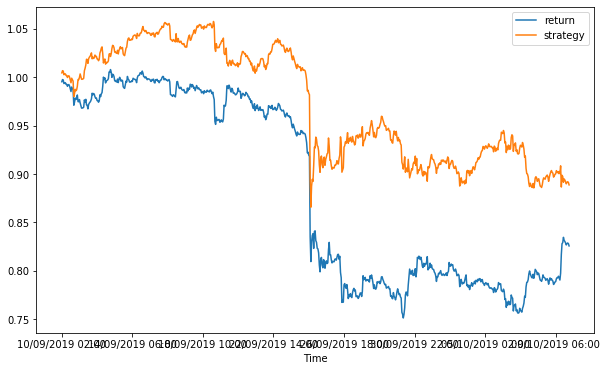

In [283]:
# Plot strategy performance
(1 + test_data[['return','strategy']]).cumprod().plot(figsize=(10,6))

#### Additional Features

In [284]:
# dataset columns
features.extend(['momentum', 'volatility', 'distance'])
cols = features.copy()
cols.append('direction')

dataset = data[cols] # Leave the return column in this dataset as it will be required later.

dataset.dropna(inplace=True)

dataset.round(4).head()

C:\Users\paul208\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
Time,,,,,,,,,
03/01/2019 02:00,-0.0011,-0.0054,-0.0014,0.0016,0.0025,-0.0008,0.0039,74.0495,0
03/01/2019 03:00,-0.0003,-0.0011,-0.0054,-0.0014,0.0016,-0.0013,0.0036,83.2954,1
03/01/2019 04:00,0.0031,-0.0003,-0.0011,-0.0054,-0.0014,-0.0010,0.0036,70.5770,0
03/01/2019 05:00,-0.0025,0.0031,-0.0003,-0.0011,-0.0054,-0.0012,0.0037,58.2516,0
03/01/2019 06:00,-0.0025,-0.0025,0.0031,-0.0003,-0.0011,-0.0007,0.0037,55.7715,1


In [285]:
# Training Dataset
training_data = dataset[:train_size].copy()

training_data.round(4).tail()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
Time,,,,,,,,,
09/09/2019 21:00,-0.0080,0.0057,-0.0015,0.0013,-0.0060,-0.0017,0.0060,-98.290,1
09/09/2019 22:00,0.0053,-0.0080,0.0057,-0.0015,0.0013,0.0005,0.0062,-42.278,1
09/09/2019 23:00,0.0051,0.0053,-0.0080,0.0057,-0.0015,0.0013,0.0061,-66.948,0
10/09/2019 00:00,-0.0027,0.0051,0.0053,-0.0080,0.0057,0.0011,0.0061,-32.402,1
10/09/2019 01:00,0.0030,-0.0027,0.0051,0.0053,-0.0080,0.0005,0.0061,-35.812,0


In [286]:
# Test Dataset
test_data = dataset[train_size:(train_size+test_size)].copy()

test_data.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
Time,,,,,,,,,
10/09/2019 02:00,-0.0006,0.0030,-0.0027,0.0051,0.0053,0.0020,0.0061,-80.602,0
10/09/2019 03:00,-0.0046,-0.0006,0.0030,-0.0027,0.0051,0.0000,0.0061,-52.614,1
10/09/2019 04:00,0.0023,-0.0046,-0.0006,0.0030,-0.0027,-0.0005,0.0055,-53.522,0
10/09/2019 05:00,-0.0004,0.0023,-0.0046,-0.0006,0.0030,-0.0001,0.0055,-88.774,0
10/09/2019 06:00,-0.0037,-0.0004,0.0023,-0.0046,-0.0006,-0.0014,0.0052,-77.440,1


In [287]:
# Standardize the datasets
mu, std = training_data.mean(), training_data.std()

training_data_ = (training_data - mu)/std

training_data_.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
Time,,,,,,,,,
03/01/2019 02:00,-0.1736,-0.7515,-0.2187,0.1841,0.3171,-0.2947,-0.5200,0.1678,-1.0498
03/01/2019 03:00,-0.0666,-0.1734,-0.7515,-0.2186,0.1841,-0.4706,-0.5765,0.2014,0.9524
03/01/2019 04:00,0.3924,-0.0664,-0.1735,-0.7515,-0.2185,-0.3749,-0.5909,0.1553,-1.0498
03/01/2019 05:00,-0.3649,0.3925,-0.0664,-0.1734,-0.7515,-0.4419,-0.5719,0.1106,-1.0498
03/01/2019 06:00,-0.3588,-0.3647,0.3925,-0.0663,-0.1733,-0.2617,-0.5608,0.1016,0.9524


In [288]:
# Standardize the test dataset
test_data_ = (test_data - mu)/std

test_data_.round(4).head()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction
Time,,,,,,,,,
10/09/2019 02:00,-0.1072,0.3758,-0.3898,0.6623,0.6925,0.5657,0.0072,-0.3931,-1.0498
10/09/2019 03:00,-0.6454,-0.1070,0.3758,-0.3897,0.6624,-0.0477,0.0116,-0.2916,0.9524
10/09/2019 04:00,0.2857,-0.6452,-0.1070,0.3759,-0.3897,-0.2203,-0.1244,-0.2948,-1.0498
10/09/2019 05:00,-0.0851,0.2859,-0.6453,-0.1069,0.3759,-0.0805,-0.1231,-0.4227,-1.0498
10/09/2019 06:00,-0.5316,-0.0849,0.2859,-0.6452,-0.1069,-0.4965,-0.2044,-0.3816,0.9524


### The Model with Additional Features

In [289]:
# Specify the optimizer
optimizer = Adam(learning_rate=0.0001)

In [290]:
# Set seeds
def set_seeds(seed=100):
    #random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)
    
set_seeds()

In [291]:
# Specify the Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(features),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [292]:
%%time
# Fit the Model
model.fit(training_data_[features], 
          training_data['direction'],
         epochs=50, verbose=False,
         validation_split=0.2, shuffle=False)

Wall time: 8.64 s


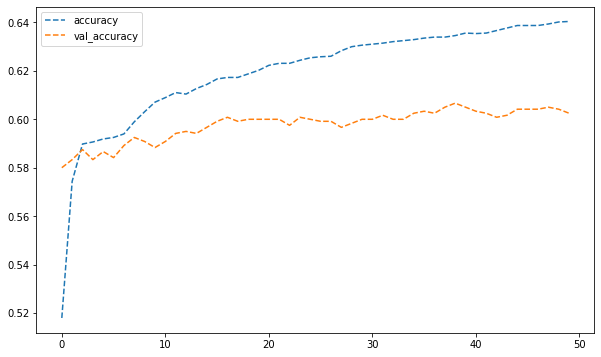

In [293]:
res = pd.DataFrame(model.history.history)

res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [294]:
# Evaluate model
model.evaluate(training_data_[features], training_data['direction'])

6000/6000 [==============================] - 0s 18us/step


[0.6425994561513265, 0.6305000185966492]

In [295]:
# Predictions
pred = np.where(model.predict(training_data_[features]) > 0.5, 1, 0)
pred[:30].flatten()

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0])

In [296]:
# Calculate the strategy returns given the positions

training_data['prediction'] = np.where(pred > 0, 1, -1)

# add return column to training_data
training_data['return'] = data[:train_size]['return']

# strategy returns
training_data['strategy'] = (training_data['prediction'] * training_data['return'])

training_data.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance,direction,prediction,return,strategy
Time,,,,,,,,,,,,
03/01/2019 02:00,-0.001091,-0.005365,-0.001425,0.001551,0.002534,-0.000759,0.003871,74.049529,0,1,-0.000300,-0.000300
03/01/2019 03:00,-0.000300,-0.001091,-0.005365,-0.001425,0.001551,-0.001326,0.003633,83.295381,1,1,0.003093,0.003093
03/01/2019 04:00,0.003093,-0.000300,-0.001091,-0.005365,-0.001425,-0.001017,0.003572,70.577018,0,1,-0.002505,-0.002505
03/01/2019 05:00,-0.002505,0.003093,-0.000300,-0.001091,-0.005365,-0.001233,0.003652,58.251618,0,1,-0.002460,-0.002460
03/01/2019 06:00,-0.002460,-0.002505,0.003093,-0.000300,-0.001091,-0.000653,0.003699,55.771460,1,1,0.000036,0.000036


In [297]:
# Total return
(1 + training_data[['return','strategy']]).prod()

return          2.695928
strategy    40361.598429
dtype: float64

In [298]:
# Check results in excel

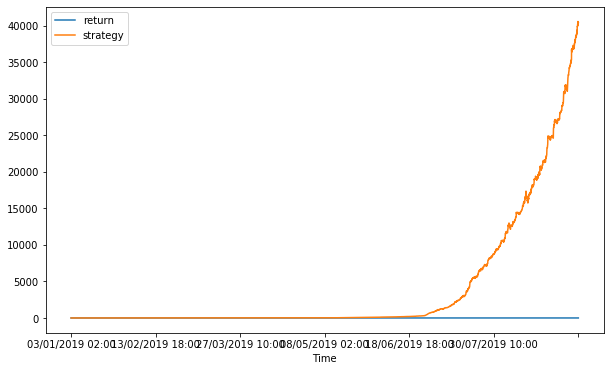

In [299]:
# Plot strategy performance (in-sample)
(1 + training_data[['return','strategy']]).cumprod().plot(figsize=(10,6))

In [300]:
# Perfomance of model on test data
model.evaluate(test_data_[features], test_data['direction'])

720/720 [==============================] - 0s 26us/step


[0.6774334245257907, 0.5972222089767456]

In [301]:
# Predictions
pred = np.where(model.predict(test_data_[features]) > 0.5, 1, 0)

test_data['prediction'] = np.where(pred > 0 , 1, -1)

test_data['prediction'].value_counts()

-1    416
 1    304
Name: prediction, dtype: int64

In [302]:
# Add returns column
test_data['return'] = data[train_size:(train_size + test_size)]['return']

# Calculate strategy returns
test_data['strategy'] = (test_data['prediction'] * test_data['return'])

(1 + test_data[['return','strategy']]).prod()

return      0.825805
strategy    2.100203
dtype: float64

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text xticklabel objects>)

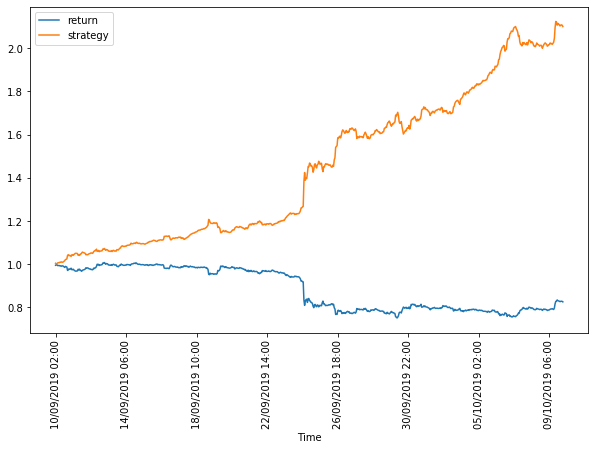

In [306]:
import matplotlib.pyplot as plt

# Plot strategy performance
(1 + test_data[['return','strategy']]).cumprod().plot(figsize=(10,6))
plt.xticks(rotation=90)

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]),
 <a list of 10 Text xticklabel objects>)

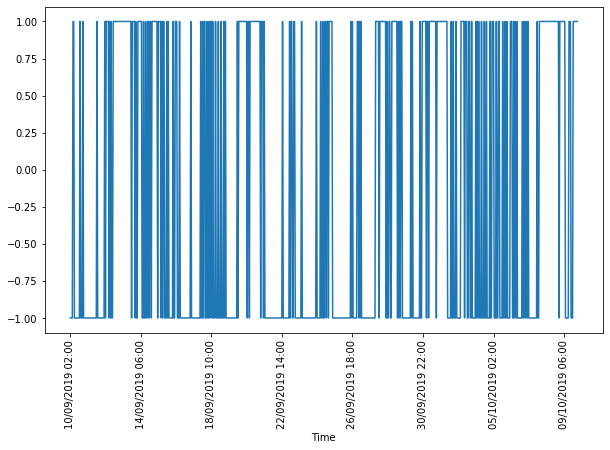

In [309]:
# Plot Positions:
test_data['prediction'].plot(figsize=(10,6))
plt.xticks(rotation=90)